# World Model Policy Evaluation

This notebook demonstrates how to rollout OpenVLA in the Bridge (WidowX) environment from within our world model, and how to grade it using a VLM.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import requests
import mediapy as media
from tqdm import tqdm
import torch
import einops
import base64
import math
import re
import cv2
from openai import OpenAI
import random
from pathlib import Path
import json

## Action scaling

In [18]:
def rescale_bridge_action(a):
    """
    Rescale Bridge (WidowX) action to the ranges expected by the world model.
    We need to call this function on the unnormalized action values returned by the policy.
    """
    wv_lo = -0.05
    wv_hi = +0.05
    wv_post_scale_max = +1.75
    wv_post_scale_min = -1.75
    rd_lo = -0.25
    rd_hi = +0.25
    rd_post_scale_max = +1.4
    rd_post_scale_min = -1.4
    # rescale end effector
    a[:3] = (a[:3] - wv_lo) / (wv_hi - wv_lo) * (
        wv_post_scale_max - wv_post_scale_min
    ) + wv_post_scale_min
    # rescale joint rotations
    a[3:6] = (a[3:6] - rd_lo) / (rd_hi - rd_lo) * (
        rd_post_scale_max - rd_post_scale_min
    ) + rd_post_scale_min
    # threshold the gripper
    a[6] = torch.where(a[6] > 0.8, -1.0, +1.0)
    return a


## VLM evaluation utils

Set your OpenAI key:
```
export OPENAI_API_KEY=<your key here>
```

In [4]:
def encode_video(video, stride=20):
    frames, idx = [], 0
    for idx, frame in enumerate(video):
        if idx % stride == 0:
            if (frame == 0).all():
                break
            _, buf = cv2.imencode(".jpg", frame)
            frames.append(base64.b64encode(buf).decode())
    return frames


def predict(video, task, n=5):
    frames = encode_video(video)
    prompt = f"""
Here is a sequence of frames from a robot policy which has been rolled out in a video-generation-based world model. I need your help determining whether the policy is successful. How successfully does the robot complete the following task?
Task: {task["instruction"]}
Subtasks: {task["subtasks"]}

For each subtask, give the model a score of 0 (fail) or 1 (success). Explain your reasoning. Finally, output "Total Score: <score>", where <score> is the sum of the scores on the subtasks above.

Note: Since this video was generated by a video prediction model (conditioned on robot actions), it may contain some artifacts due to the video model capacity.
Note: For the final score output, make sure to follow the "Total Score: <score>" format exactly so the score can be parsed out using a regex.
""".strip()
    client = OpenAI()
    messages = [
        {
            "role": "user",
            "content": [prompt, *[{"image": f, "resize": 256} for f in frames]],
        }
    ]
    print(prompt)
    res = client.chat.completions.create(model="gpt-4o", messages=messages, n=n)
    total_score = 0
    n_scores = 0
    for c in res.choices:
        print(c.message.content)
        m = re.search(r"Total Score: (\d+)", c.message.content.replace("**", ""))
        if m:
            total_score += (
                int(m.group(1)) / 2.0
            )  # divide by 2 since there are 2 subtasks
            n_scores += 1
    avg_score = total_score / n_scores
    print(f"Average Score: {avg_score}")
    return avg_score

## Policy Evaluation Loop

In [19]:
def evaluate_policy(vla, tasks, rollout_length=40):
    """
    Rollout an OpenVLA model on a list of tasks, and return the score on each task.
    Arguments:
        vla: An OpenVLA model from `transformers`
        tasks: A list of N tasks in loaded from a json. See "put_carrot_on_plate.json" for an example of the format.
    Returns:
        scores: A list of N scores from the VLM corresponding to each input task.
    """
    scores = []
    for task_i in tqdm(tasks, desc="completing tasks"):
        start_frame = np.array(
            Image.open(requests.get(task_i["im_0_path"], stream=True).raw).resize(
                (256, 256)
            )
        )
        media.show_image(start_frame)
        wm.reset(torch.from_numpy(start_frame).cuda().float() / 255.0)

        frames = [start_frame]
        for step in tqdm(range(rollout_length)):
            curr_frame = Image.fromarray(frames[-1])
            prompt = f"In: What action should the robot take to {task_i['instruction']}?\nOut:"
            inputs = processor(prompt, curr_frame).to(
                device="cuda", dtype=torch.bfloat16
            )
            actions = vla.predict_action(
                **inputs, unnorm_key="bridge_orig", do_sample=False
            )

            a = torch.tensor(actions)[0].cuda()
            # NOTE: OpenVLA outputs 7-dim actions, while the world model was trained with up to 10-dim actions.
            a = torch.cat([a, a.new_zeros(3)], dim=-1)  # pad with zeros
            a = rescale_bridge_action(a)

            for i, x in wm.generate_chunk(a):
                new_frame = x[0, 0].cpu().numpy()
                new_frame = np.clip(new_frame * 255, 0, 255).astype(np.uint8)
                frames.append(new_frame)
        rollout_video = np.stack(frames)
        media.show_video(rollout_video, fps=20)
        avg_score = predict(rollout_video, task=task_i)
        scores.append(avg_score)
    return np.array(scores)

## Init world model

In [ ]:
# Download the BridgeV2 checkpoint if needed
ckpt_path = Path("bridge_v2_ckpt.pt")
if not ckpt_path.exists():
    import gdown
    with ckpt_path.open("wb") as f:
        gdown.download("https://drive.google.com/file/d/1otjQTpxdiUXiKFmMDwlpy46zPOkFxEfA/view?usp=sharing", f, fuzzy=True)

In [21]:
from world_model import WorldModel

wm = WorldModel(ckpt_path)

## Init OpenVLA

In [16]:
from transformers import AutoModelForVision2Seq, AutoProcessor

# Load Processor & VLA
processor = AutoProcessor.from_pretrained("openvla/openvla-7b", trust_remote_code=True)
vla = AutoModelForVision2Seq.from_pretrained(
    "openvla/openvla-7b",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).cuda()

/matx/u/quevedo/miniconda3/envs/robots311/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
0.00B [03:36, ?B/s]
0.00B [02:19, ?B/s]
  0%|                                                                                                                 | 0.00/2.43G [01:27<?, ?B/s]
0.00B [02:09, ?B/s]
/matx/u/quevedo/miniconda3/envs/robots311/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.56it/s]


completing tasks:   0%|                                                                                                     | 0/1 [00:00<?, ?it/s]

""

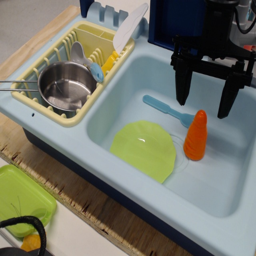


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:40<00:00,  1.01s/it]


Here is a sequence of frames from a robot policy which has been rolled out in a video-generation-based world model. I need your help determining whether the policy is successful. How successfully does the robot complete the following task?
Task: place the carrot on plate
Subtasks: ['Pick up the carrot.', 'Place the carrot on the plate.']

For each subtask, give the model a score of 0 (fail) or 1 (success). Explain your reasoning. Finally, output "Total Score: <score>", where <score> is the sum of the scores on the subtasks above.

Note: Since this video was generated by a video prediction model (conditioned on robot actions), it may contain some artifacts due to the video model capacity.
Note: For the final score output, make sure to follow the "Total Score: <score>" format exactly so the score can be parsed out using a regex.


completing tasks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:47<00:00, 47.95s/it]

To assess the robot's performance on the task of placing a carrot on a plate, I'll evaluate each subtask:

1. **Pick up the carrot.**
   - The first image shows the robot claw approaching the carrot.
   - The second image depicts the claw closing around the carrot.
   - The third image suggests the carrot is successfully lifted by the claw.
   - **Score: 1 (success).**

2. **Place the carrot on the plate.**
   - In the third image, the carrot appears to be positioned above the plate, but without evidence that it is placed on the plate.
   - There is no indication that the carrot has been released onto the plate.
   - **Score: 0 (fail).**

Total Score: 1
Based on the sequence of frames provided:

### Subtask 1: Pick up the carrot.
- **Observation**: The carrot (depicted as a blue object) is successfully grasped by the robot's gripper.
- **Score**: 1 (success)

### Subtask 2: Place the carrot on the plate.
- **Observation**: The carrot appears to be hovering above the plate but is not cl

array([0.7])

In [22]:
# Some example task specifications are already provided. You can create more of these .jsons by collecting
# URLs from the raw Bridge dataset: https://rail-berkeley.github.io/bridgedata/
task_files = ["put_carrot_on_plate.json", "put_eggplant_into_pot_or_pan.json"]
task_file = Path(task_files[0])
with task_file.open("r") as f:
    tasks = json.load(f)
tasks = tasks[:1]  # rollout just the first trial as a test
evaluate_policy(vla, tasks)